In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch import optim
import os
import numpy as np
import copy
import time
import matplotlib.pyplot as plt

In [2]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
# 데이터를 불러오는 경로를 설정
data_dir = './test_set'
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
               for x in ['train','val']}
# 데이터로더를 불러오는 설정
dataloaders={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=0)
            for x in ['train','val']}
dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
# CUDA(GPU 가속화)사용이 가능하게 만드는 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

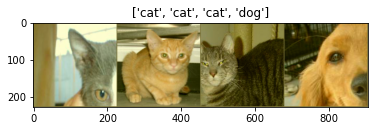

In [3]:
# 사용하게 될 데이터를 시각화하기
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.225])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# 학습 데이터의 배치를 얻는 과정
inputs, classes = next(iter(dataloaders['train']))
# 배치로부터 격자 형태의 grid를 만드는 과정
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
class GoogLeNet(nn.Module):
    def __init__(self,aux_logits=True, num_classes=2, init_weights=True):
        super(GoogLeNet, self).__init__()
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits

        # conv_block takes in_channels, out_channels, kernel_size, stride, padding
        # Inception block takes out1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool

        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, 2, 1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, 2, 1)
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, 2, 1)
        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)

        # auxiliary classifier

        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)

        # auxiliary classifier

        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, 2, 1)
        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(7, 1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        else:
            self.aux1 = self.aux2 = None

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)

        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)

        x = x.view(x.shape[0], -1)

        x = self.dropout(x)
        x = self.fc1(x)

        if self.aux_logits and self.training:
            return x, aux1, aux2
        else:
            return x 

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.conv_layer(x)


class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1)
        )

    def forward(self, x):
        # 0차원은 batch이므로 1차원인 filter 수를 기준으로 각 branch의 출력값을 묶어줍니다. 
        x = torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)
        return x

# auxiliary classifier의 loss는 0.3이 곱해지고, 최종 loss에 추가합니다. 정규화 효과가 있습니다. 
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),
            conv_block(in_channels, 128, kernel_size=1),
        )

        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [5]:
model = GoogLeNet(aux_logits=True, num_classes=2, init_weights=True).to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output)

(tensor([[-0.1752, -0.0226],
        [ 0.0396, -0.2808],
        [-0.3017, -0.1590]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[-0.1082,  0.1041],
        [ 0.0285,  0.0096],
        [-0.0664,  0.1430]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[-0.1133, -0.0538],
        [ 0.0255, -0.1681],
        [ 0.0602, -0.1124]], device='cuda:0', grad_fn=<AddmmBackward0>))


In [6]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import StepLR
lr_scheduler = StepLR(opt, step_size=30, gamma=0.1)

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']



def metric_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects



def loss_batch(loss_func, outputs, target, opt=None):
#     print(type(outputs))
    if type(outputs) == type(()):
        output, aux1, aux2 = outputs
        
#         print(len(outputs))
        output_loss = loss_func(output, target)
        aux1_loss = loss_func(aux1, target)
        aux2_loss = loss_func(aux2, target)

        loss = output_loss + 0.3*(aux1_loss + aux2_loss)
        metric_b = metric_batch(output,target)

    else:
        loss = loss_func(outputs, target)
        metric_b = metric_batch(outputs, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return loss.item(), metric_b



def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        
        output= model(xb)
#         print(np.shape(output[0]))
#         print(len(output))
#         print(type(output))
#         for i in output:
#             print(i)
#         output = torch.tensor(output)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric



def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')
    
    start_time = time.time()
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)
#         print('----------------------')
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        lr_scheduler.step()

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' 
              %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [7]:
# definc the training parameters
params_train = {
    'num_epochs':70,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':dataloaders['train'],
    'val_dl':dataloaders['val'],
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [8]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/69, current lr=0.001
Copied best model weights!
train loss: 1.186374, val loss: 0.704347, accuracy: 49.55, time: 0.5509 min
----------
Epoch 1/69, current lr=0.001
train loss: 1.143503, val loss: 1.040846, accuracy: 52.73, time: 1.0983 min
----------
Epoch 2/69, current lr=0.001
Copied best model weights!
train loss: 1.145844, val loss: 0.668793, accuracy: 60.45, time: 1.6571 min
----------
Epoch 3/69, current lr=0.001
train loss: 1.119574, val loss: 1.029322, accuracy: 58.64, time: 2.2030 min
----------
Epoch 4/69, current lr=0.001
train loss: 1.105148, val loss: 0.712841, accuracy: 59.09, time: 2.7481 min
----------
Epoch 5/69, current lr=0.001
train loss: 1.103809, val loss: 0.671636, accuracy: 63.18, time: 3.3045 min
----------
Epoch 6/69, current lr=0.001
Copied best model weights!
train loss: 1.085805, val loss: 0.664488, accuracy: 63.18, time: 3.8527 min
----------
Epoch 7/69, current lr=0.001
Copied best model weights!
train loss: 1.101982, val loss: 0.646874, accuracy:

train loss: 0.601629, val loss: 0.223051, accuracy: 93.18, time: 35.0090 min
----------
Epoch 64/69, current lr=1e-05
train loss: 0.631369, val loss: 0.217788, accuracy: 90.00, time: 35.5504 min
----------
Epoch 65/69, current lr=1e-05
train loss: 0.606173, val loss: 0.247623, accuracy: 90.45, time: 36.0940 min
----------
Epoch 66/69, current lr=1e-05
train loss: 0.608689, val loss: 0.202996, accuracy: 91.82, time: 36.6389 min
----------
Epoch 67/69, current lr=1e-05
train loss: 0.588504, val loss: 0.213306, accuracy: 90.45, time: 37.1810 min
----------
Epoch 68/69, current lr=1e-05
train loss: 0.623193, val loss: 0.210982, accuracy: 91.82, time: 37.7267 min
----------
Epoch 69/69, current lr=1e-05
train loss: 0.625513, val loss: 0.205389, accuracy: 94.09, time: 38.2740 min
----------


https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/Classification/GoogLeNet(2014).ipynb

In [9]:
#이미지에 대한 예측값을 보여주는 함수
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labesl = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs,1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted:{}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)

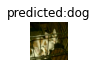

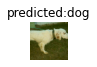

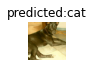

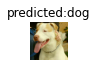

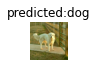

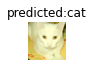

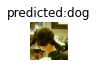

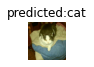

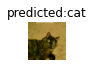

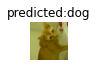

In [10]:
visualize_model(model)

plt.ioff()
plt.show()